<a href="https://colab.research.google.com/github/yodavo/IAI_vaccines/blob/main/data_wrangling/dataWrangling_VAERSdata-VAERSvax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paquetes

In [1]:
# Para importar la data
import os

# Importar para manipulacion de datos
import numpy as np
import pandas as pd
import datetime as dt

# Importar para Visualizacion 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
sns.set(style="ticks", context='talk', palette='Paired_r')
import warnings # para evitar warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Importar Dependencias
%matplotlib inline
%load_ext google.colab.data_table

# Acondicionamiento de Drive y Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Entrando a la carpeta de trabajo
%cd '/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset


# Carga de datos

In [3]:
# Carga de datos

# importar de VAERSData
data = pd.read_csv('2021VAERSData.csv', index_col=0, encoding='latin-1')
print(f'VAERSData\ttiene: {data.shape[0]} observaciones y {data.shape[1]} variables.')

# importar de VAERSVAX
vax = pd.read_csv('2021VAERSVAX.csv', index_col=0, encoding='latin-1')
print(f'VAERSVAX\ttiene: {vax.shape[0]} observaciones y {vax.shape[1]} variables.')

# importar de VAERSSymptoms
symptom = pd.read_csv('2021VAERSSYMPTOMS.csv', index_col=0, encoding='latin-1')
print(f'VAERSSymptoms\ttiene: {symptom.shape[0]} observaciones y {symptom.shape[1]} variables.')

VAERSData	tiene: 428486 observaciones y 34 variables.
VAERSVAX	tiene: 445358 observaciones y 7 variables.
VAERSSymptoms	tiene: 575022 observaciones y 10 variables.


# Preparacion de datos de vacunas (**VAERSVAX**)

Se utilizo informacion de VAX_MANU y VAX_TYPE para hacer el filtro de:

1.**VAX_MANU** -- Para eliminar 'UNKNOWN MANUFACTURER'
2.**VAX_TYPE** -- Para filtrar vacunas de COVID19

**Una vez usadas se eliminaron las siguientes variables:**
1. **VAX_NAME** (por tener la misma informaciond de VAX_MANU)
2.**VAX_TYPE** (por que despues del filtrado no aporta mas informacion)

In [4]:
# TRATANDO VAX
# eliminamos frabricante desconocido y seleccionamos solamente los datos de covid19
vac = vax.loc[(vax['VAX_MANU'] != 'UNKNOWN MANUFACTURER') & (vax['VAX_TYPE'] == 'COVID19')] 
print(vac.shape)

(437645, 7)


In [5]:
# eliminamos repetidos y variables de filtrado
vacuna = vac.loc[vac.index.drop_duplicates(keep=False)]
vacuna.drop(columns = ['VAX_NAME', 'VAX_TYPE'], inplace = True)
print(vacuna.shape) # no duplicados, lista para ser combinada

(409006, 5)


In [6]:
# separando el dataset de vacunas de covid19
print(f"Tamaño dataset original: {vax.shape[0]} observaciones y {vax.shape[1]} variables")
print(f"Tamaño dataset COVID19: {vacuna.shape[0]} observaciones y {vacuna.shape[1]} variables")

Tamaño dataset original: 445358 observaciones y 7 variables
Tamaño dataset COVID19: 409006 observaciones y 5 variables


# Merge de datasets **VAERVAX** (vacuna) y **VAERSData** (data), basada en 'vacuna' - variable global : **dataset_covid**

Lamentablemente, el dataset sympthoms esta contaminado con informacion de laboratorio, medicamenttos y otros. Por lo que no fue tomada en cuenta para el analisis.

In [7]:
dataset_covid = pd.merge(vacuna, data, on='VAERS_ID')
print(f'El dataset de VAERS para vacunas covid tiene: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables')

El dataset de VAERS para vacunas covid tiene: 409006 observaciones y 39 variables


# **Variables que no aportan informacion para este estudio**

1. **RPT_DATE** -- Fecha de llenado del reporte, no es necesaria para este estudio (preferimos la fecha de carga del reporte).
2. **SPLTTYPE** -- Numero de proyecto de fabricante, no es necesaria para este estudio.
3. **TODAYS_DATE** -- Fecha de subida a la base de datos, no es indispensable.


In [8]:
## Variables no necesarias
rejected_col = ['RPT_DATE', 'SPLTTYPE', 'TODAYS_DATE']
print(f"Antes: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")
dataset_covid.drop(rejected_col, axis=1, inplace=True)
print(f"Despues: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")

Antes: 409006 observaciones y 39 variables
Despues: 409006 observaciones y 36 variables


# **Variables que necesitan observación por el metodo de coleccion de datos**

1. **FORM_VERS ** -- En la colecta de los datos, tenemos dos factores importantes, primero la naturaleza del formulario que se utilizo para **(FORM_VERS)** teniendo dos formularios:

  - Form1 - Impreso (289 observaciones)
  - Form2 - Online (408717 observaciones)

  Como observamos la version impresa tiene una cantidad no significativa en comparacion de los otros datos. **Lo que nos permite eliminarla.**

  **En consecuencia de la eliminacion de los formularios 1,** existen otras variables tomadas juntamente con este formato, que se analiza a continuación:
  2. **V_FUNDBY** -- Tipos de financiamiento usado para la vacunación. **Se elimino por poseer data insuficiente.**

  3. **VAX_DOSE_SERIES** -- Numero de dosis administradas. Esta variable no es confiable debido a su *descontinuacion* en el formulario. A pesar de eso se relizo una limpieza a traves de la eliminacion de observaciones (fila entera) donde se observo mas de 3 dosis de vacunas. Importante saber que en estos casos excedentes, se observaron: 
    - MODERNA (644 obs excedentes de 3 dosis)
    - PFIZER-BIONTECH (585 obs excedentes de 3 dosis)
    - JANSSEN (85 obs excedentes de 3 dosis)
  
    **Reportando 11 fallecidos (por Moderna y Pfizer) y 17 hospitalizados por todas las vacunas (para mas detalle ver el codigo abajo).** Una vez usado para el filtro, se conservo la variables para separar por grupos de dosis de vacunas (para evaluar)

  4. **HISTORY** -- Condiciones cronicas y enfermedades duraderas reportadas. Al momento de analizar la informacion se vio una cantidad de datos considerable por lo que se dio incio con la creacion de una lista de palabras a ignorar (**'palabras_erroneas', importante por que usara para todo el dataset**, ya que será actualizado en cada variable que reciba variables textuales) y **se observó que la variable tenian un valor significativo en el dataset, por lo que no fue eliminada y sera procesada por NPL mas adelante.**
  5.**ER_VISIT** -- Solo tenia 50 records. Visita a sala de emergencia o doctor. Debido a que tiene similitud con otras variables sera procesada mas adelante.





In [9]:
# Filtrando FORM_VERS para quedarnos solo con formularios 2
dataset_covid = dataset_covid.loc[dataset_covid.FORM_VERS == 2]
# Eliminando la variable FORM_VERS ya que no sera necesaria para mas adelante
dataset_covid.drop(columns= 'FORM_VERS', inplace=True)

In [10]:
# Eliminando la variable V_FUNDBY por ser desestimada por pocos datos sginificativos
dataset_covid.drop(columns= 'V_FUNDBY', inplace=True)

In [11]:
# Analisis de VAX_DOSE_SERIES
dataset_covid['VAX_DOSE_SERIES'] = dataset_covid['VAX_DOSE_SERIES'].str.lower().replace('unk', np.nan) # reemplazando valores desconocidos (UNK)

# revision de dosis exageradas (ESTA SECCION ES SOLO PARA REPORTE, LOS DATOS SE ELIMINARON DE LA BASE DE DATOS)
outliers_dosis = dataset_covid.loc[dataset_covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]
print(f'Valores fuera de los rangos de estudio: \n')
print(outliers_dosis.VAX_MANU.value_counts())
print(f'\nValores de fallecidos: \n')
print(outliers_dosis.groupby(['VAX_MANU', 'DIED']).size())
print(f'\nValores de hospitalizados: \n')
print(outliers_dosis.groupby(['VAX_MANU', 'HOSPITAL']).size())

# eiminar valores de dosis excedentes
print(f"\n\nAntes: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")
dataset_covid = dataset_covid[~dataset_covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]
print(f"Despues: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables")

# imputacion de los datos bajo el enunciado "todos los reportes tienen almenos 1 dosis de vacunas"
dataset_covid.VAX_DOSE_SERIES.fillna(1, inplace =True) # se asume que los valores vacios son al menos al 1era dosis

Valores fuera de los rangos de estudio: 

MODERNA            278
PFIZER\BIONTECH    110
JANSSEN             61
Name: VAX_MANU, dtype: int64

Valores de fallecidos: 

VAX_MANU         DIED
MODERNA          Y       9
PFIZER\BIONTECH  Y       2
dtype: int64

Valores de hospitalizados: 

VAX_MANU         HOSPITAL
JANSSEN          Y            2
MODERNA          Y           11
PFIZER\BIONTECH  Y            4
dtype: int64


Antes: 408717 observaciones y 34 variables
Despues: 408268 observaciones y 34 variables


In [12]:
# Creacion de las lista de palabras_erroneas (palabras a ignorar)
palabras_errones = ['none', 'no', 'comments: unknown', 'unknown',
                    'comments: list of non-encoded patient relevant history: patient other relevant history 1: none',
                    'medical history/concurrent conditions: no adverse event (no reported medical history)', 
                    'none reported', 'medical history/concurrent conditions: no adverse event (no medical history reported)',
                    'medical history/concurrent conditions: no adverse event (no reported medical history.)',
                    'none known', 'na', 'medical history/concurrent conditions: no adverse event (no medical history reported.)',
                    'none listed', 'unk', 'comments: the patient had no known allergies.', 'no.', 
                    '0', 'non', 'yes', 'none noted', 'none stated', 'no known', 'comments: list of non-encoded patient relevant history: patient other relevant history 1: no',
                    'nothing', 'comments: no medical history was provided by the reporter.',
                    'comments: list of non-encoded patient relevant history: patient other relevant history 1: no',
                    'comments: the patient had no known drug allergies.', 'nothing'
]

# Se analizara HISTORY mas adelante cuando se utilice NPL

# **Filtrado de Variables.**

##**1.RECVDATE**

Fecha de ingreso de reporte. Sin cambio

In [13]:
# Procesamiento de RECVDATE, formato de fecha
dataset_covid['RECVDATE'] =  dataset_covid['RECVDATE'].apply(pd.to_datetime, format='%m/%d/%Y') # no contiene ningun valor vacio

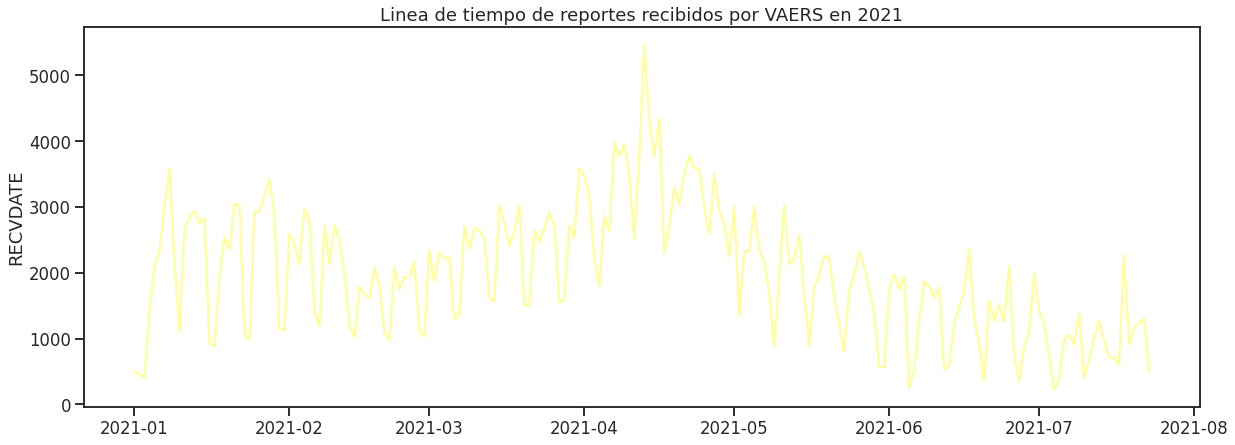

In [14]:
# variable para plotear
recvdate = dataset_covid['RECVDATE'].value_counts()

# grafico de fecha de ingreso de reportes
plt.figure(figsize=(20,7))
sns.lineplot(data = recvdate)
plt.title('Linea de tiempo de reportes recibidos por VAERS en 2021')
plt.show()


## **2. STATE**

Se conservaron solo estados de USA, los territorios y nan fueron cambiados por **NSP**

In [15]:
# Lista  de estados de los Estados Unidos de America
usa_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [16]:
# Obteniendo datos erroneos para correcion
dataset_covid['STATE'] = dataset_covid['STATE'].str.upper() # volver tod el codigo a mayusculas
dataset_covid['STATE'] = dataset_covid['STATE'].str.strip() # quitar espacios en blanco
erroneo = dataset_covid['STATE'].value_counts().index.tolist() # seleccionar valores para comparar con los estados
cambio = list(set(erroneo) - set(usa_states)) # para comprobar la differencia
for i in cambio:
  print(i, dataset_covid.loc[dataset_covid['STATE'] == i].shape)

VI (32, 34)
PR (1495, 34)
MH (7, 34)
GU (58, 34)
MP (13, 34)
XL (1, 34)
FM (3, 34)
XV (2, 34)
QM (1, 34)
XB (3, 34)
AS (33, 34)


In [17]:
#reemplazo de valores y valores nan
dataset_covid['STATE'] = dataset_covid['STATE'].replace(cambio, np.nan) # reemplazando los valores de territorios
dataset_covid['STATE'] = dataset_covid['STATE'].fillna('NSP') # definiendo no especifica

## **3. AGE_YRS, CAGE_YR, CAGE_MO**

Se combino CAGE_YR y CAGE_MO para rescatar la edad si no fue brindada en AGE_YRS.
Se convitieron las edades en numeros integrales y todo se establecio en la variable AGE_YRS

In [18]:
# Analisis por datos vacios
print(dataset_covid.AGE_YRS.isnull().sum(), dataset_covid.AGE_YRS.dtype)
print(dataset_covid.CAGE_YR.isnull().sum(), dataset_covid.CAGE_YR.dtype)
print(dataset_covid.CAGE_MO.isnull().sum(), dataset_covid.CAGE_MO.dtype)

27890 float64
61722 float64
407494 float64


In [19]:
# revisamos cuantos datos podemos recuperar las edades
print('Se puede recuperar: ', dataset_covid.loc[~dataset_covid['CAGE_YR'].isnull()].AGE_YRS.isnull().sum(), 'edades no anotadas')

Se puede recuperar:  1466 edades no anotadas


In [20]:
#Preparamos la nueva columna
dataset_covid.AGE_YRS = dataset_covid.AGE_YRS.fillna(0).astype('int')
dataset_covid.CAGE_YR = dataset_covid.CAGE_YR.fillna(0).astype('int') # cambiamos tipo para concatenar
dataset_covid.CAGE_MO = dataset_covid.CAGE_MO.fillna(0).astype('int') # cambiamos tipo para concatenar

In [21]:
# creamos una nueva columna
dataset_covid['EDADexp'] = dataset_covid.CAGE_YR.astype(str) + '.' + dataset_covid.CAGE_MO.astype(str)
dataset_covid['EDADexp'] = dataset_covid['EDADexp'].astype(float).round()
dataset_covid['EDADexp'] = dataset_covid['EDADexp'].astype(int)

In [22]:
# Recuperando valores en AGE_YRS
print('Antes de recuperar las edades de CAGE se tenian:\t', dataset_covid.loc[dataset_covid['AGE_YRS'] != 0].shape[0], 'observaciones')
dataset_covid['AGE_YRS'] = np.where(dataset_covid['AGE_YRS'] == 0, dataset_covid['EDADexp'], dataset_covid['AGE_YRS'])
print('Despues de recuperar las edades de CAGE se tienen:\t', dataset_covid.loc[dataset_covid['AGE_YRS'] != 0].shape[0], 'observaciones')

Antes de recuperar las edades de CAGE se tenian:	 380318 observaciones
Despues de recuperar las edades de CAGE se tienen:	 381623 observaciones


In [23]:
# Eliminamos las columnas que no nos brindan mas datos utiles
remove = ['EDADexp', 'CAGE_YR', 'CAGE_MO']
dataset_covid.drop(columns=remove, inplace=True)

## **4. SEX**

Se eliminaron los record con sexo desconocido (U)

In [24]:
print(f'Antes de eliminar los sexos desconocidos se tenian {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables')
# Eliminamos valores U, no aportan nada al estudio
dataset_covid = dataset_covid.loc[dataset_covid['SEX'] != 'U']
print(f'Despues de eliminar los sexos desconocidos se tenian {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables')
print(dataset_covid.SEX.value_counts())

Antes de eliminar los sexos desconocidos se tenian 408268 observaciones y 32 variables
Despues de eliminar los sexos desconocidos se tenian 398229 observaciones y 32 variables
F    285023
M    113206
Name: SEX, dtype: int64


## **5. DIED, DATE_DIED**

Se conservo, se confirmo la muerte y luego se mejoro los errores en la fecha.

In [25]:
# Analisis por datos vacios
print(dataset_covid.DIED.notnull().sum(), dataset_covid.DIED.dtype)
print(dataset_covid.DATEDIED.notnull().sum(), dataset_covid.DATEDIED.dtype)

4850 object
4489 object


In [26]:
# Preparando DIED, solo se imputo los valores vacios por N
dataset_covid.DIED = dataset_covid.DIED.fillna('N').astype('str')

In [27]:
# Preparando los datos de DATEDIED
new = dataset_covid["DATEDIED"].str.split("/", n = 2, expand = True)
dataset_covid['mes']= new[0]
dataset_covid['dia']= new[1]
dataset_covid['anio']= new[2]

# lista para uso con fechas
new = ['mes','dia','anio']

#revision de todo
# for i in new:
#   display(dataset_covid[i].value_counts().sort_index())

# El problema detectado fue el año
display(dataset_covid['anio'].value_counts().sort_index())

2001       1
2010       1
2014       1
2020      31
2021    4455
Name: anio, dtype: int64

In [28]:
# revisando valores atipicos
dataset_covid.loc[dataset_covid['anio'].isin(['2001','2010','2014'])]

,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,RECVDATE,STATE,AGE_YRS,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,mes,dia,anio
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
930912,PFIZER\BIONTECH,NaN,1,UN,UN,2021-01-09,NY,73,M,Diarrhea followed by death 24 hrs after vaccin...,Y,01/08/2001,NaN,NaN,NaN,NaN,NaN,NaN,N,01/07/2021,01/08/2021,1.0,NaN,UNK,None,None,None,NaN,NaN,NaN,NaN,None,01,08,2001
1050128,PFIZER\BIONTECH,EM9810,1,IM,LA,2021-02-23,WV,70,M,"02/07/21 through 2/13/21 slightly fatiqued, to...",Y,02/14/2014,NaN,NaN,NaN,NaN,NaN,NaN,N,02/06/2021,02/07/2021,1.0,NaN,PUB,"Eliquis 5MG, Carvedilol 6.25MG, Ramipril 2.5 M...",none,1.COPD started in 2008 from a Neurosurgery and...,NaN,NaN,NaN,Y,Penicillin,02,14,2014
1133747,MODERNA,030M20A,1,IM,LA,2021-03-25,NSP,97,M,died on hospice Narrative: Patient died on ho...,Y,03/14/2010,NaN,NaN,NaN,NaN,Y,NaN,N,NaN,03/14/2021,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,03,14,2010


 Revision, se reemplaza los años por revision individual de la siguiente manera

 - 2001 -> 2021
 - 2021 -> 2021
 - 2014 -> 2021

In [29]:
# Reemplazando valores
dataset_covid['anio'].replace({'2001': '2021', 
                               '2010': '2021',
                               '2014': '2021'}, inplace=True)

# funcion para reemplazar tiempo
dataset_covid.DATEDIED = dataset_covid['anio'] + '-' + dataset_covid['mes'] + '-' + dataset_covid['dia']

# eliminando columnas temporales
dataset_covid.drop(columns=new, inplace=True)

# transformando a fecha
dataset_covid['DATEDIED'] =  pd.to_datetime(dataset_covid['DATEDIED'], format='%Y-%m-%d')

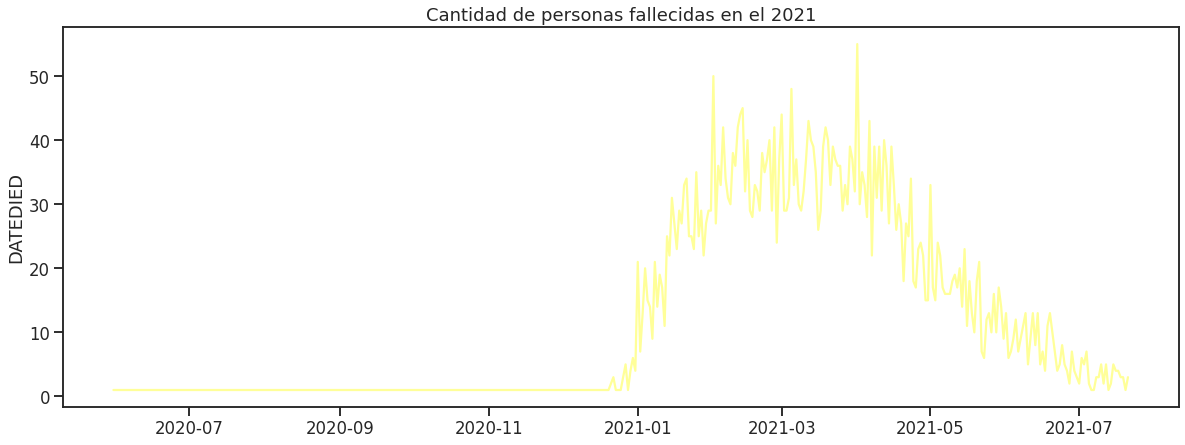

In [30]:
# grafico por fechas y de personas fallecidas
plt.figure(figsize=(20,7))
sns.lineplot(data = dataset_covid['DATEDIED'].value_counts())
plt.title('Cantidad de personas fallecidas en el 2021')
plt.show()

## **6.ER_VISIT, ER_ED_VISIT, OFC_VISIT**

En el caso de las dos primeras tienen la mismas info pero estan colectadas en diferentes formulario.

En el caso de la tercera contiene informacion explicita en ER_VISIT por lo que se todas estas variables se combinaron en ER_ED_VISIT.


Se transformo Y en 1 y nan n 0

In [31]:
print(f'Valores vacios en ER_ED_VISIT:\t{dataset_covid.ER_ED_VISIT.isnull().sum()}')
print(f'Valores vacios en ER_VISIT:\t{dataset_covid.ER_VISIT.isnull().sum()}')
print(f'Valores vacios en OFC_VISIT:\t{dataset_covid.OFC_VISIT.isnull().sum()}')

Valores vacios en ER_ED_VISIT:	344579
Valores vacios en ER_VISIT:	398229
Valores vacios en OFC_VISIT:	319279


In [32]:
# preparando las columnas para ser combinadas (imputando por binario)
dataset_covid.ER_VISIT.fillna(0, inplace=True)
dataset_covid.ER_ED_VISIT.fillna(0, inplace=True)
dataset_covid.OFC_VISIT.fillna(0, inplace=True)

In [33]:
# preparando formato de columnas
er_ed = dataset_covid['ER_ED_VISIT'].astype(str)
er_vi = dataset_covid['ER_VISIT'].astype(str)
of_vi = dataset_covid['OFC_VISIT'].astype(str)

# combinando las columnas en una sola variable (ER_ED_VISIT)
dataset_covid.ER_ED_VISIT = er_ed + er_vi + of_vi

# revisando valores
dataset_covid.ER_ED_VISIT.value_counts()

000    281957
00Y     62622
Y00     37322
Y0Y     16328
Name: ER_ED_VISIT, dtype: int64

In [34]:
# reemplazando valores
dataset_covid['ER_ED_VISIT'].replace({'000': 0, 
                               'Y00': 1,
                               'Y0Y': 1,
                               '00Y': 1}, inplace=True)

# revisando valores
dataset_covid.ER_ED_VISIT.value_counts()

0    281957
1    116272
Name: ER_ED_VISIT, dtype: int64

In [35]:
print(f'Antes del filtrado teniamos {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')
# Eliminamos variables que ya no son utiles ('ER_VISIT', 'OFC_VISIT')
dataset_covid.drop(columns=['ER_VISIT', 'OFC_VISIT'], inplace=True)
print(f'Despues del filtrado teniamos {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')

Antes del filtrado teniamos 398229 observaciones y 32 variables.
Despues del filtrado teniamos 398229 observaciones y 30 variables.


## **7.HOSPITAL, HOSPDAYS**

Se imputo con 0 los valores valores faltante y se cambio Y por 1 en hospitalizados.

Los dias de hospitalizacin llegan hasta 120 dias.

In [36]:
# imputamos valores en dias con 0 y volvemos binario en hospitalizacion
dataset_covid.HOSPITAL.fillna(0, inplace=True) # imputando nan por 0 en hospitalizados
dataset_covid.HOSPDAYS.fillna(0, inplace=True) # imputando nan por 0 en dias hospitalizados
dataset_covid.HOSPITAL.replace('Y',1, inplace=True) # cambiamos y por 1 en hospitalizados

# coercionamos los valores a int
dataset_covid.HOSPITAL = dataset_covid.HOSPITAL.astype(int)
dataset_covid.HOSPDAYS = dataset_covid.HOSPDAYS.astype(int)

In [37]:
# revisando valores
A = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL != 0)
B = (dataset_covid.HOSPDAYS == 0) & (dataset_covid.HOSPITAL != 0)
C = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL == 0)

# comprobando que los valores sean iguales!
print('Datos de pacientes hospitalizados (Y)\t:', (dataset_covid.HOSPITAL != 0).sum())
print('Al menos 1 dia de hospitalizacion\t:', (dataset_covid.HOSPDAYS != 0).sum())
print(f'Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[A].shape[0]}')
print(f'Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[B].shape[0]}')
print(f'Pacientes con datos dias de hospitalizacion y sin record de hospitalizado (Y) : {dataset_covid.loc[C].shape[0]}')

Datos de pacientes hospitalizados (Y)	: 22362
Al menos 1 dia de hospitalizacion	: 15900
Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : 15900
Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : 6462
Pacientes con datos dias de hospitalizacion y sin record de hospitalizado (Y) : 0


Se pueden mejorar los datos en base al siguiente enunciado.

> Todo paciente hospitalizados (Y) deben tener al menos 1 dia de hospitalizacion.

In [38]:
# cambio usando condicional (B) previamente usada
dataset_covid['HOSPDAYS'] = np.where(B, 1, dataset_covid['HOSPDAYS'])

In [39]:
# revisando valores
A = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL != 0)
B = (dataset_covid.HOSPDAYS == 0) & (dataset_covid.HOSPITAL != 0)
C = (dataset_covid.HOSPDAYS != 0) & (dataset_covid.HOSPITAL == 0)

# comprobando nuevamente
print(f'Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[A].shape[0]}')
print(f'Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : {dataset_covid.loc[B].shape[0]}')

Pacientes con datos dias de hospitalizacion y con record de hospitalizado (Y) : 22362
Pacientes sin datos dias de hospitalizacion y con record de hospitalizado (Y) : 0


In [40]:
# revisando valores excedentes en HOSPDAYS
dataset_covid.HOSPDAYS = np.where(dataset_covid.HOSPDAYS > 120, 0, dataset_covid.HOSPDAYS) # para eliminar valores 999 999 99999
dataset_covid.HOSPDAYS.value_counts().sort_index()

0      375869
1        9382
2        3488
3        2737
4        1770
        ...  
95          1
97          1
104         1
117         1
120         2
Name: HOSPDAYS, Length: 76, dtype: int64

## **8. L_THREAT**

Cambio de Y por 1 y nan por 0

In [41]:
# cambiando por valores binarios
dataset_covid.L_THREAT.fillna('0', inplace=True) # rellenando nan con 0
dataset_covid.L_THREAT.replace('Y', 1, inplace=True)
dataset_covid.L_THREAT = dataset_covid.L_THREAT.astype(int) # voviendolo int
dataset_covid.L_THREAT.value_counts()

0    391767
1      6462
Name: L_THREAT, dtype: int64

## **9. DISABLE**

Cambio de Y por 1 y nan po 0

In [42]:
# cambiando por valores binarios
dataset_covid.DISABLE.fillna('0', inplace=True) # rellenando nan con 0
dataset_covid.DISABLE.replace('Y', 1, inplace=True)
dataset_covid.DISABLE = dataset_covid.DISABLE.astype(int) # voviendolo int
dataset_covid.DISABLE.value_counts()

0    392691
1      5538
Name: DISABLE, dtype: int64

## **10. BIRTH_DEFECT, X_STAY**

Ambas no representa un valor significante (solo 199 pacientes en BIRTH DEFECT y 235 en X_STAY), ademas no especifica el defecto de nacimiento por lo que no es indispensable para este estudio, ni la cantidad de dias de hospitalizacion excedente.

**Ambas fueron eliminadas.**

In [43]:
print(f'Antes del filtro se tenian: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')
dataset_covid.drop(columns=['BIRTH_DEFECT','X_STAY'], inplace=True)
print(f'Despues del filtro se tenian: {dataset_covid.shape[0]} observaciones y {dataset_covid.shape[1]} variables.')

Antes del filtro se tenian: 398229 observaciones y 30 variables.
Despues del filtro se tenian: 398229 observaciones y 28 variables.


## **11.RECOVD**

Se imputaron con valores U (desconocidos) de periodos de recuperacion de los pacientes. Necesita mas evaluacion.

In [44]:
print(f'Antes de imputar:\n{dataset_covid.RECOVD.value_counts()}\n')
# imputanod valores
dataset_covid.RECOVD.fillna('U', inplace=True)
print(f'Despues de imputar:\n{dataset_covid.RECOVD.value_counts()}\n')

Antes de imputar:
N    147669
Y    144558
U     67393
Name: RECOVD, dtype: int64

Despues de imputar:
N    147669
Y    144558
U    106002
Name: RECOVD, dtype: int64



## **12. VAX_DATE, VAX_ONSET**
Multiples errores, corregidos y mapeado desde la informacion de fecha de reporte del formulario. 

In [45]:
# Preparando los datos de VAX_DATE
new_vax = dataset_covid["VAX_DATE"].str.split("/", n = 2, expand = True)
dataset_covid['mes_vax']= new_vax[0]
dataset_covid['dia_vax']= new_vax[1]
dataset_covid['anio_vax']= new_vax[2]

# lista para uso con fechas
new_vax = ['mes_vax','dia_vax','anio_vax']

# revision de todo
# for i in new_vax:
#  display(dataset_covid[i].value_counts().sort_index())

In [46]:
# Preparando los datos de ONSET_DATE
new_ons = dataset_covid["ONSET_DATE"].str.split("/", n = 2, expand = True)
dataset_covid['mes_ons']= new_ons[0]
dataset_covid['dia_ons']= new_ons[1]
dataset_covid['anio_ons']= new_ons[2]

# lista para uso con fechas
new_ons = ['mes_ons','dia_ons','anio_ons']

# revision de todo
# for i in new_ons:
#  display(dataset_covid[i].value_counts().sort_index())

> El problema detectado fueron los **años**, y se hara un filtro para revisar si esta informacion es recuperable

In [47]:
# creamos una lista de revision
revisar1 = dataset_covid['anio_vax'].dropna().astype(float).astype(int)
revisar1 = list(set([str(x) for x in revisar1 if x < 2020]))
#revisar1 # lista de años errados en vax

revisar2 = dataset_covid['anio_ons'].dropna().astype(float).astype(int)
revisar2 = list(set([str(x) for x in revisar2 if x < 2020]))
#revisar2 # lista de años errados en ons

# El problema detectado fue el año en ambos casps
# display(dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar2)])

In [48]:
## Preparando columnas para arreglar años, imputando con 0s y conviertiendo en int para poder comparar
dataset_covid.anio_vax.fillna(0, inplace=True)
dataset_covid.anio_vax = dataset_covid.anio_vax.astype(float).astype(int)
dataset_covid.anio_ons.fillna(0, inplace=True)
dataset_covid.anio_ons = dataset_covid.anio_ons.astype(float).astype(int)

In [49]:
# Arreglando anio_ons

# Preprando correccion
anos_correctos = ['2020', '2021']

# Comparando años
criterio = (dataset_covid.anio_vax.isin(anos_correctos)) & ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
# dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_ons'] = np.where(criterio, dataset_covid['anio_vax'], dataset_covid['anio_ons'])

# revisando si los valores siguen errados
criterio = (dataset_covid.anio_vax.isin(anos_correctos)) & ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


In [50]:
# Arreglando anio_vax

# Preprando correccion
anos_correctos = ['2020', '2021']

# Comparando años
criterio = (dataset_covid.anio_ons.isin(anos_correctos)) & ~(dataset_covid.anio_vax.isin(anos_correctos)) & (dataset_covid.anio_vax != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
#dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_vax'] = np.where(criterio, dataset_covid['anio_ons'], dataset_covid['anio_vax'])

# revisando si los valores siguen errados
criterio = (dataset_covid.anio_vax.isin(anos_correctos)) & ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


> A pesar de las mejoras, el problema sigue por lo que se repite nuevamente

In [51]:
# modificamos la lista de revision para ver errores
revisar1 = dataset_covid['anio_vax']
revisar = [x for x in revisar1 if x < 2020]
revisar2 = dataset_covid['anio_ons']
revisar += [x for x in revisar2 if x < 2020]
revisar = list(set(revisar))
revisar.remove(0) #eliminamos valores 0

print(revisar) # lista de años errados en vax
print('Valores errados en anio_vax: ', dataset_covid.loc[dataset_covid['anio_vax'].isin(revisar)].shape[0])
print('Valores errados en anio_ons: ', dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar)].shape[0])

[1921, 1941, 1944, 1951, 1958, 1961, 1964, 1969, 1970, 1977, 1986, 1988, 1995, 1996, 2000, 2001, 2005, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Valores errados en anio_vax:  83
Valores errados en anio_ons:  48


In [52]:
# Extraemos el año de la presentacion del reporte para hacer una comparacion
dataset_covid['anio_reporte'] = pd.DatetimeIndex(dataset_covid['RECVDATE']).year

In [53]:
# Arreglando anio_vax 

# Comparando años
criterio = ~(dataset_covid.anio_vax.isin(anos_correctos)) & (dataset_covid.anio_vax != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
#dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_vax'] = np.where(criterio, dataset_covid['anio_reporte'], dataset_covid['anio_vax'])

# revisando si los valores siguen errados
criterio = ~(dataset_covid.anio_vax.isin(anos_correctos)) & (dataset_covid.anio_vax != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


In [54]:
# Comprobamos
# modificamos la lista de revision para ver errores
revisar1 = dataset_covid['anio_vax']
revisar = [x for x in revisar1 if x < 2020]
revisar2 = dataset_covid['anio_ons']
revisar += [x for x in revisar2 if x < 2020]
revisar = list(set(revisar))
revisar.remove(0) #eliminamos valores 0

print(revisar) # lista de años errados en vax
print('Valores errados en anio_vax: ', dataset_covid.loc[dataset_covid['anio_vax'].isin(revisar)].shape[0])
print('Valores errados en anio_ons: ', dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar)].shape[0])

[1921, 2019, 1988, 2015, 1958, 1995, 1996, 2000, 2001, 1970, 1941, 1944, 1977, 2010, 2012, 2013, 1951]
Valores errados en anio_vax:  0
Valores errados en anio_ons:  48


In [55]:
# Arreglando anio_ons

# Comparando años
criterio = ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)
# el criterio es para buscar el error en anios_ons, revisar la linea de abajo para mas comprension
#dataset_covid.loc[criterio] # revisando

# Reemplazamos el cambio usando condicional (criterio)
dataset_covid['anio_ons'] = np.where(criterio, dataset_covid['anio_reporte'], dataset_covid['anio_ons'])

# revisando si los valores siguen errados
criterio = ~(dataset_covid.anio_ons.isin(anos_correctos)) & (dataset_covid.anio_ons != 0)

print(f"Despues de la correcion tenemos {dataset_covid.loc[criterio].shape[0]} valores errados bajo la condicion descrita")

Despues de la correcion tenemos 0 valores errados bajo la condicion descrita


In [56]:
# Comprobamos
# modificamos la lista de revision para ver errores
revisar1 = dataset_covid['anio_vax']
revisar = [x for x in revisar1 if x < 2020]
revisar2 = dataset_covid['anio_ons']
revisar += [x for x in revisar2 if x < 2020]
revisar = list(set(revisar))
revisar.remove(0) #eliminamos valores 0

print(revisar) # lista de años errados en vax
print('Valores errados en anio_vax: ', dataset_covid.loc[dataset_covid['anio_vax'].isin(revisar)].shape[0])
print('Valores errados en anio_ons: ', dataset_covid.loc[dataset_covid['anio_ons'].isin(revisar)].shape[0])

[]
Valores errados en anio_vax:  0
Valores errados en anio_ons:  0


> Errores de fecha corregidos


In [57]:
# comprobacion de correcion de errores
print(dataset_covid.anio_vax.value_counts())
print(dataset_covid.anio_ons.value_counts())

2021    363463
2020     18843
0        15923
Name: anio_vax, dtype: int64
2021    372642
0        13116
2020     12471
Name: anio_ons, dtype: int64


> Conversion de fechas

In [58]:
#regresanod valores a string para poder hacer concatenacion de fechas
dataset_covid.anio_vax = dataset_covid.anio_vax.astype(str)
dataset_covid.anio_ons = dataset_covid.anio_ons.astype(str)

In [59]:
# Reemplazando valores
dataset_covid.anio_vax.replace({0 : np.nan}, inplace=True)
dataset_covid.anio_ons.replace({0 : np.nan}, inplace=True)

In [60]:
# funcion para reemplazar tiempo
dataset_covid['VAX_DATE'] = dataset_covid['anio_vax'] + '-' + dataset_covid['mes_vax'] + '-' + dataset_covid['dia_vax']
dataset_covid['ONSET_DATE'] = dataset_covid['anio_ons'] + '-' + dataset_covid['mes_ons'] + '-' + dataset_covid['dia_ons']

# transformando a fecha
dataset_covid['VAX_DATE'] =  pd.to_datetime(dataset_covid['VAX_DATE'], format='%Y-%m-%d')
dataset_covid['ONSET_DATE'] =  pd.to_datetime(dataset_covid['ONSET_DATE'], format='%Y-%m-%d')

In [61]:
# eliminando columnas temporales
remove_col = new_vax + new_ons + ['anio_reporte']
dataset_covid.drop(columns=remove_col, inplace=True)

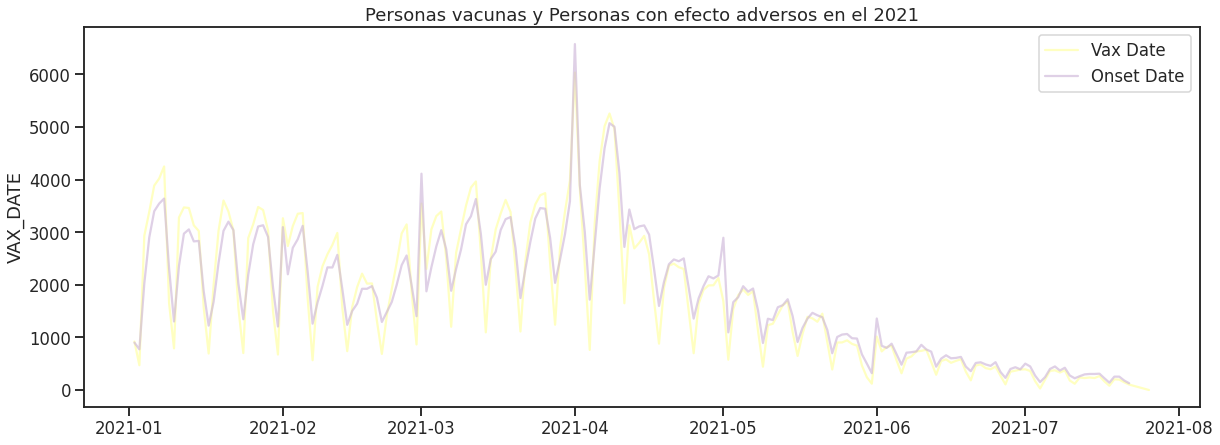

In [62]:
# # revisar esto, sigue habiendo problemas con las fechas
# fig1 = plt.figure(figsize=(20,7))
# ax = fig1.add_subplot(1, 1, 1)
# x = sns.lineplot(data = dataset_covid.VAX_DATE.value_counts(),ax=ax, label=str('Vax Date'), alpha=0.6)
# z = sns.lineplot(data = dataset_covid.ONSET_DATE.value_counts(),ax=ax,label=str('Onset Date'), alpha=0.6)
# plt.legend()
# plt.title('Personas vacunas y Personas con efecto adversos en el 2021')
# plt.show()

# criterio vax
criterio_vax = (dataset_covid['VAX_DATE'] > '2021-01-01') & (dataset_covid['VAX_DATE'] < '2021-08-01')
# criterio onset
criterio_ons = (dataset_covid['ONSET_DATE'] > '2021-01-01') & (dataset_covid['ONSET_DATE'] < '2021-08-01')

# grafico
fig1 = plt.figure(figsize=(20,7))
ax = fig1.add_subplot(1, 1, 1)
x = sns.lineplot(data = dataset_covid.loc[criterio_vax].VAX_DATE.value_counts(),ax=ax, label=str('Vax Date'), alpha=0.6)
z = sns.lineplot(data = dataset_covid.loc[criterio_ons].ONSET_DATE.value_counts(),ax=ax,label=str('Onset Date'), alpha=0.6)
plt.legend()
plt.title('Personas vacunas y Personas con efecto adversos en el 2021')
plt.show()

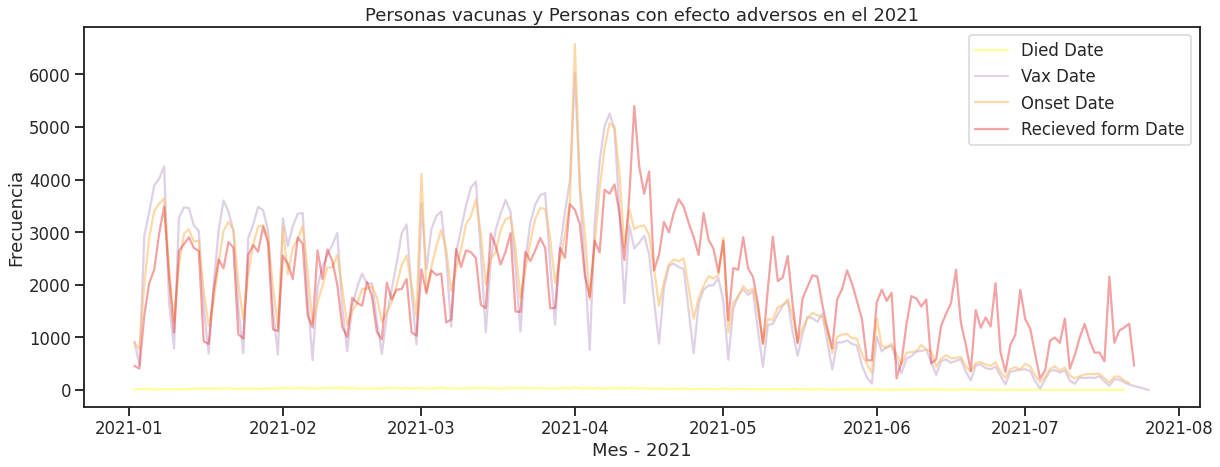

In [63]:
# grafico de todas las fechas
fig1 = plt.figure(figsize=(20,7))
ax = fig1.add_subplot(1, 1, 1)
a = sns.lineplot(data = dataset_covid.loc[(dataset_covid['DATEDIED'] > '2021-01-01') & (dataset_covid['DATEDIED'] < '2021-08-01')].DATEDIED.value_counts(),ax=ax,label=str('Died Date'))
x = sns.lineplot(data = dataset_covid.loc[(dataset_covid['VAX_DATE'] > '2021-01-01') & (dataset_covid['VAX_DATE'] < '2021-08-01')].VAX_DATE.value_counts(),ax=ax, label=str('Vax Date'), alpha=0.6)
z = sns.lineplot(data = dataset_covid.loc[(dataset_covid['ONSET_DATE'] > '2021-01-01') & (dataset_covid['ONSET_DATE'] < '2021-08-01')].ONSET_DATE.value_counts(),ax=ax,label=str('Onset Date'), alpha=0.6)
y = sns.lineplot(data = dataset_covid.loc[(dataset_covid['RECVDATE'] > '2021-01-01') & (dataset_covid['RECVDATE'] < '2021-08-01')].RECVDATE.value_counts(),ax=ax,label=str('Recieved form Date'), alpha=0.4)
plt.legend()
ax.set_xlabel('Mes - 2021')
ax.set_ylabel('Frecuencia')
plt.title('Personas vacunas y Personas con efecto adversos en el 2021')
plt.show()

## **13.NUMDAYS**

Eliminada

In [64]:
# numero de dias desde el dia del efecto adverso 
# aqui hay datos muy ERRADOs
dataset_covid.NUMDAYS.dropna().astype(int).value_counts().sort_index(ascending=False).head(100).index

Int64Index([36896, 36573, 36564, 36561, 36555, 36553, 36545, 36542, 36541,
            36535, 36534, 36533, 36532, 36531, 36530, 36529, 36528, 36527,
            36526, 36525, 36519, 34252, 30961, 30492, 30376, 29698, 29539,
            29492, 29221, 29110, 28943, 28347, 28177, 28078, 27436, 27394,
            27157, 27036, 26599, 26543, 26180, 26176, 26146, 25873, 25760,
            25503, 25059, 24926, 24855, 24643, 24627, 24618, 24584, 24221,
            23962, 23913, 23834, 23780, 23768, 23744, 23400, 23395, 23193,
            23087, 22977, 22790, 22764, 22647, 22511, 22498, 22477, 22143,
            22103, 22084, 22009, 21934, 21933, 21915, 21863, 21790, 21784,
            21379, 21332, 21311, 21295, 21239, 21113, 21090, 21001, 20905,
            20857, 20631, 20576, 20462, 20323, 20283, 20212, 20202, 20148,
            20102],
           dtype='int64')

In [65]:
dataset_covid.NUMDAYS.dropna().astype(int).value_counts().sort_index(ascending=False).tail(100).index

Int64Index([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
            82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
            65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
            48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
            31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
            14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
           dtype='int64')

In [66]:
# eliminamos variable
print(f'Antes: {dataset_covid.shape}')
dataset_covid.drop(columns='NUMDAYS', inplace=True)
print(f'Despues: {dataset_covid.shape}')

Antes: (398229, 28)
Despues: (398229, 27)


## **14.ADMINBY**

Administracion de la vacuna, conservada y necesita discusion.

In [67]:
# Lugar donde se puso la vacuna
print(dataset_covid.V_ADMINBY.dropna().str.upper().value_counts(ascending = True))
print(dataset_covid.V_ADMINBY.isnull().sum())

MIL     5609
SCH     7477
SEN     7724
WRK    16445
PUB    49745
OTH    68715
UNK    69812
PHM    74109
PVT    98593
Name: V_ADMINBY, dtype: int64
0


**Conversar sobre este asunto... para ver el public objetivo....**

## **15. VAX_LOT, VAX_ROUTE, VAX_SITE**

In [68]:
# Por recomendacion del profesor, conservamos el lote de la vacuna
dataset_covid.VAX_LOT.dropna().value_counts()

Unknown    4474
026L20A    2938
039K20A    2838
EK9231     2792
011J20A    2492
           ... 
014m208       1
013LOZA       1
039k207       1
EIM0162       1
0198          1
Name: VAX_LOT, Length: 17452, dtype: int64

In [69]:
# imputar los datos con 'Unknown'
dataset_covid.VAX_LOT.fillna('Unknown', inplace=True)
print(dataset_covid.VAX_LOT.dropna().value_counts())

Unknown     126243
026L20A       2938
039K20A       2838
EK9231        2792
011J20A       2492
             ...  
dn184367         1
VA               1
031L7OA          1
EW172            1
E 51686          1
Name: VAX_LOT, Length: 17452, dtype: int64


In [70]:
# ruta de inoculacion de la vacuna .. interesante...
print(dataset_covid.VAX_ROUTE.fillna('UN', inplace=True))
print(dataset_covid.VAX_ROUTE.value_counts())

None
IM     209046
UN      90636
SYR     86874
OT       9988
SC       1332
ID        268
JET        80
IN          3
PO          2
Name: VAX_ROUTE, dtype: int64


**Investigar aqui,en esta seccion hay buenos un buen corte.**

In [71]:
# zona anatomica de inoculacion de vacuna
print(dataset_covid.VAX_SITE.fillna('UN', inplace=True))
dataset_covid.VAX_SITE.value_counts() # La mayoria cae en LA (Left Arm) y RA (rigth Arm)

None


LA    229308
UN     84022
RA     76950
AR      7379
OT       333
LL       117
RL        97
GM         9
LG         6
MO         4
NS         4
Name: VAX_SITE, dtype: int64

# **Revisión completa del dataset e imputacion final**


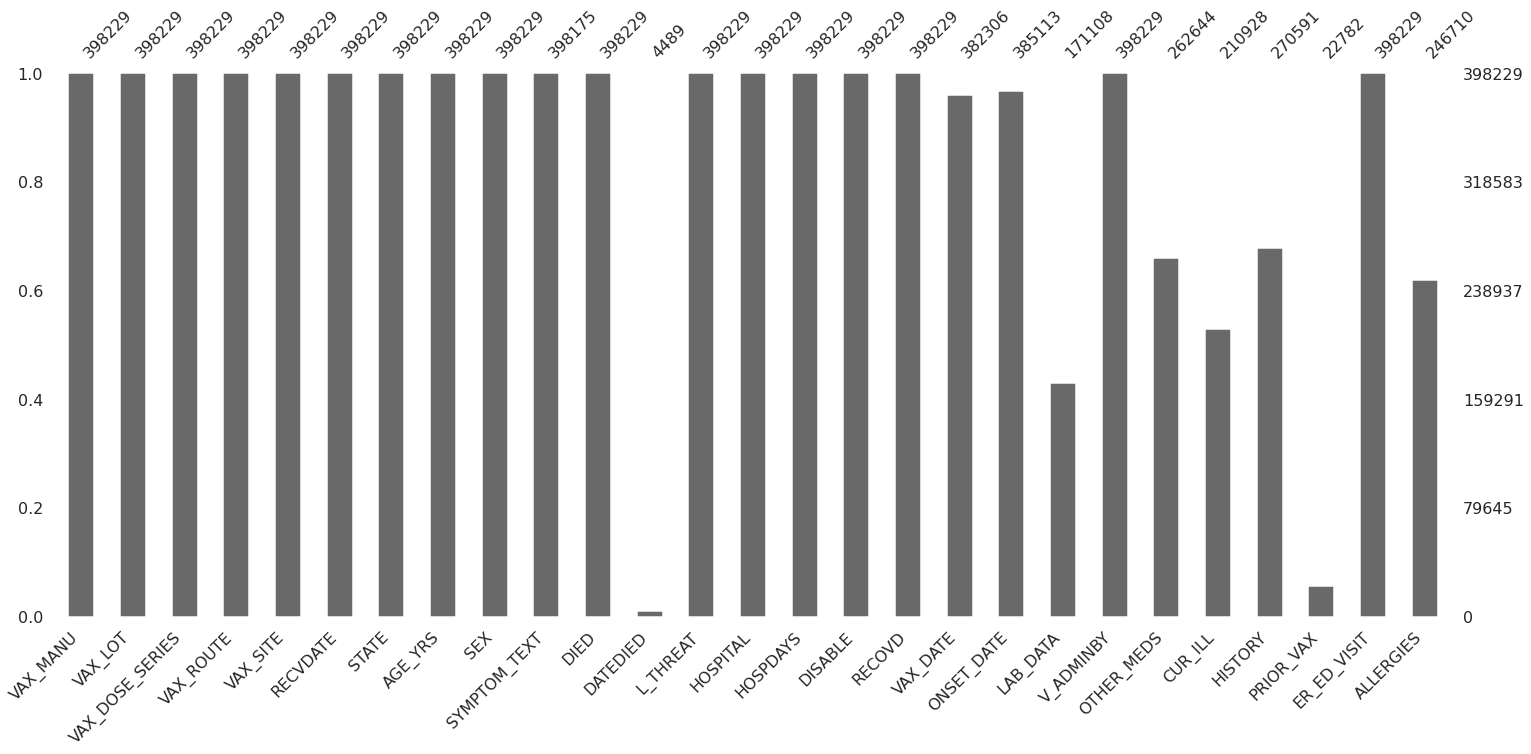

In [72]:
msno.bar(dataset_covid)
plt.show()

In [73]:
# reordenando la data
dataset_limpio = dataset_covid[['RECVDATE', 'VAX_LOT', 'VAX_MANU', 'VAX_DOSE_SERIES',
                                'VAX_ROUTE', 'VAX_SITE', 'VAX_DATE', 'ONSET_DATE',
                                'STATE','V_ADMINBY', 'AGE_YRS', 'SEX', 'ER_ED_VISIT',
                                'L_THREAT', 'DISABLE', 'DIED', 'DATEDIED', 
                                'PRIOR_VAX', 'SYMPTOM_TEXT', 'LAB_DATA', 'HISTORY', 
                                'OTHER_MEDS', 'CUR_ILL', 'ALLERGIES', 'HOSPITAL', 
                                'HOSPDAYS', 'RECOVD',                                 
                                ]].copy()

In [74]:
# guardamos el dataset
dataset_limpio.to_csv("dataset_limpio.csv")

# redefinimos el dataset ordenado
dataset_covid = dataset_limpio.copy()

# **Recurriendo al corte solicitado por el equipo**

- VAX_MANU -> PFIZER
- HOSPITAL -> 1 (hospitalizados)



In [75]:
# creamos criteria
criteria = (dataset_covid.VAX_MANU == 'PFIZER\BIONTECH') & (dataset_covid.HOSPITAL == 1)
# realizamos la separacion
dataset_covid = dataset_covid.loc[criteria]

In [76]:
# debido al corte eliminamos las variables que ya no aportan diferencia
dataset_covid.drop(columns=['VAX_MANU', 'HOSPITAL'], inplace=True)

In [77]:
# Analisis de VAX_DATE
dataset_covid.VAX_DATE = dataset_covid.VAX_DATE.dt.strftime('%Y-%m-%d')

#Arreglos personalizados
dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == '2021-09-09', np.nan , dataset_covid.VAX_DATE)
dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == '2021-07-05', '2021-07-05' , dataset_covid.VAX_DATE)
dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == '2020-01-04', '2021-01-04' , dataset_covid.VAX_DATE)
dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == '2020-01-22', '2021-01-22' , dataset_covid.VAX_DATE)
dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == '2020-04-26', '2021-04-26' , dataset_covid.VAX_DATE)
dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == '2020-06-04', '2021-06-04' , dataset_covid.VAX_DATE)
dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == '2020-07-05', '2021-07-05' , dataset_covid.VAX_DATE)

#algunos que no tenian sentido por las fechas
borrar_VAX = ['2021-11-09','2021-10-08', '2021-12-29', '2021-09-01', '2021-12-01',
              '2021-12-01', '2020-01-17', '2020-10-01', '2020-06-24',  ]
for i in borrar_VAX:
  dataset_covid.VAX_DATE = np.where(dataset_covid.VAX_DATE == i, np.nan, dataset_covid.VAX_DATE)

# retornando a VAX_DATE
dataset_covid.VAX_DATE = dataset_covid.VAX_DATE.apply(pd.to_datetime, format='%Y-%m-%d')

In [78]:
# Analisis de ONSET_DATE
dataset_covid.ONSET_DATE = dataset_covid.ONSET_DATE.dt.strftime('%Y-%m-%d')

#Arreglos personalizados
dataset_covid.ONSET_DATE = np.where(dataset_covid.ONSET_DATE == '2020-07-10', '2021-07-10' , dataset_covid.ONSET_DATE)

# datos erroneos
borrar_ONSET = ['2021-09-01', '2020-11-01', ]
for i in borrar_ONSET:
  dataset_covid.ONSET_DATE = np.where(dataset_covid.ONSET_DATE == i, np.nan, dataset_covid.ONSET_DATE)

# retornando a VAX_DATE
dataset_covid.ONSET_DATE = dataset_covid.ONSET_DATE.apply(pd.to_datetime, format='%Y-%m-%d')

In [79]:
# eliminar columnas con vacunas del 2020 e informe muy tardio en el 2021
dataset_covid.drop(1183985, axis=0, inplace=True)

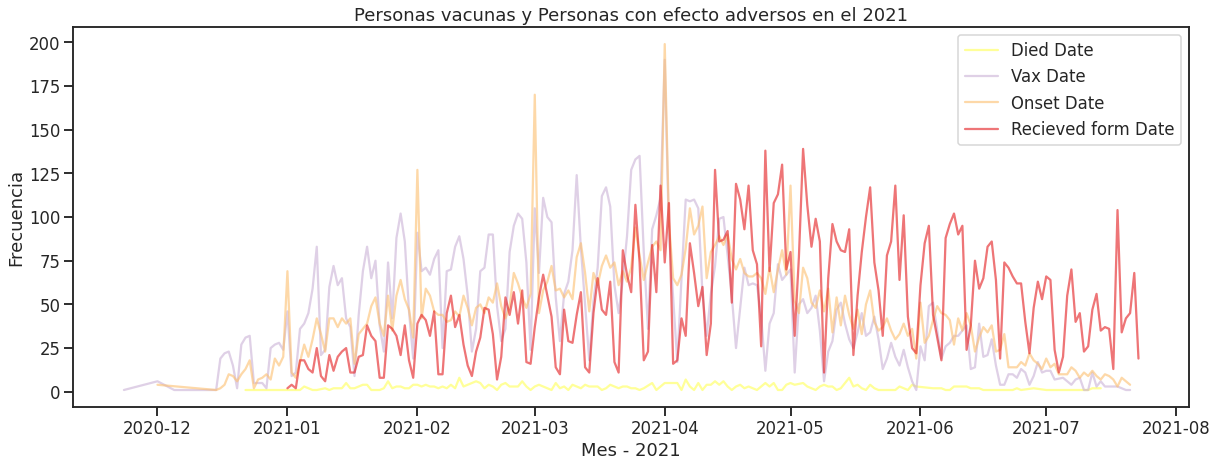

In [80]:
# grafico de todas las fechas
fig1 = plt.figure(figsize=(20,7))
ax = fig1.add_subplot(1, 1, 1)
a = sns.lineplot(data = dataset_covid.DATEDIED.value_counts(),ax=ax,label=str('Died Date'))
x = sns.lineplot(data = dataset_covid.VAX_DATE.value_counts(),ax=ax, label=str('Vax Date'), alpha=0.6)
z = sns.lineplot(data = dataset_covid.ONSET_DATE.value_counts(),ax=ax,label=str('Onset Date'), alpha=0.6)
y = sns.lineplot(data = dataset_covid.RECVDATE.value_counts(),ax=ax,label=str('Recieved form Date'), alpha=0.6)
plt.legend()
ax.set_xlabel('Mes - 2021')
ax.set_ylabel('Frecuencia')
plt.title('Personas vacunas y Personas con efecto adversos en el 2021')
plt.show()

In [81]:
dataset_covid.loc[(dataset_covid.VAX_DATE < '2021-01-01') | (dataset_covid.ONSET_DATE < '2021-01-01')].shape

(298, 25)

# Exportacion del dataset para modelar

In [82]:
# guardamos el dataset
dataset_covid.to_csv("pfizer_limpio.csv")

Se continuara en otro notebook para el analisis de textos...